In [1]:
import os
import shutil
from pathlib import Path

import jax.random as jr
import jax.numpy as jnp
from omegaconf import OmegaConf
import matplotlib.pyplot as plt

from cohlib.utils import pickle_open
from cohlib.jax.dists import sample_from_gamma
from cohlib.jax.observations import add0



In [2]:
def naive_estimator(spikes, nonzero_inds=None):
    "spikes has shape (time, unit, trial)"
    n_f0 = jnp.fft.rfft(spikes, axis=0)
    n_f = n_f0[1:,:,:]
    naive_est = jnp.einsum('jkl,jil->jkil', n_f, n_f.conj()).mean(-1)

    if nonzero_inds is None:
        return naive_est
    else:
        return naive_est[nonzero_inds, :, :]


In [3]:
def clean_dir(path):
    _dir = Path(path)
    for i, exp in enumerate(_dir.glob('*')):
        exp_path = Path(exp)
        contents = []
        for f in exp_path.glob('*'):
            contents.append(os.path.split(f)[1])
        if 'res.pickle' not in contents: 
            shutil.rmtree(exp_path)
            print('Removing unfinished experiment')

In [4]:
def check_attrs(cfg, lcfg_attrs, mcfg_attrs, ocfg_attrs):    
    lcfg_check = [cfg.latent.get(k, None) == v for k, v in lcfg_attrs.items()]
    mcfg_check = [cfg.model.get(k, None) == v for k, v in mcfg_attrs.items()]
    ocfg_check = [cfg.obs.get(k, None) == v for k, v in ocfg_attrs.items()]

    check = jnp.all(jnp.array(lcfg_check + mcfg_check + ocfg_check))
    return check

def filter_load_results(paths, lcfg_attrs, mcfg_attrs, ocfg_attrs):
    sel_paths = []
    for path in paths:
        _dir = Path(path)
        for i, exp in enumerate(_dir.glob('*')):
            cfg_path = os.path.join(exp, '.hydra/config.yaml')
            cfg = OmegaConf.load(cfg_path)

            if check_attrs(cfg, lcfg_attrs, mcfg_attrs, ocfg_attrs):
                sel_paths.append(exp)

    assert len(sel_paths) > 0
    print(f'{len(sel_paths)} paths found meeting critera')

    results = []
    for path in sel_paths:
        cfg_path = os.path.join(path, '.hydra/config.yaml')
        cfg = OmegaConf.load(cfg_path)

        res = pickle_open(os.path.join(path, 'res.pickle'))
        res['cfg'] = cfg
        results.append(res)

    return results


def filter_loaded(loaded, lcfg_attrs, mcfg_attrs, ocfg_attrs):
    filtered = [r for r in loaded if check_attrs(r['cfg'], lcfg_attrs, mcfg_attrs, ocfg_attrs)]
    if len(filtered) == 0:
        print("No results in list to filter.")
    elif len(filtered) == 1:
        print("Returned single result.")
        return filtered[0]
    else:
        print("Multiple results found.")
        return filtered

In [5]:
def transform(spec, dB=True):
    if dB is True:
        return 10*jnp.log10(spec+1e-15)
    else:
        return spec

In [6]:
alpha = 200
num_iters = 50
lcfg_attrs = {'scale': 1e4}

# mcfg_attrs = {'init': 'empirical-diag-init',
mcfg_attrs = {'init': 'empirical-init',
              'emiters': num_iters}

ocfg_attrs = {'obs_type': 'pp_relu',
              'alpha': alpha}

In [7]:
res_paths = ['/projectnb/stephenlab/jtauber/cohlib/hydra/pp_relu_obs/outputs/2024-09-16']
for res_path in res_paths:
    clean_dir(res_path)

results = filter_load_results(res_paths, lcfg_attrs, mcfg_attrs, ocfg_attrs)
Ls = sorted([r['cfg'].latent.L for r in results])
print(Ls)

3 paths found meeting critera
[10, 25, 50]


Returned single result.


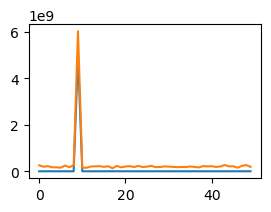

In [8]:
L = Ls[2]
lsel = {'L': L}
res = filter_loaded(results, lsel, {}, {})

gamma_true = res['gamma_true_full']
gamma_est = res['gamma']
gamma_init = res['gamma_init']
nz = jnp.arange(50)
k = 0
fig,ax = plt.subplots(figsize=(3,2))
ax.plot(gamma_true[nz,k,k].real)
# ax.plot(gamma_est[:,k,k].real)
ax.plot(gamma_init[:,k,k].real)
# plt.ylim([0,1e6])

In [9]:
gamma_init[9,:,:]

Array([[6.0139832e+09+1.3520334e+03j, 3.7997504e+09-4.0228769e+09j],
       [3.7997491e+09+4.0228800e+09j, 6.7504481e+09+1.4400168e+03j]],      dtype=complex64)

Returned single result.
Returned single result.
Returned single result.


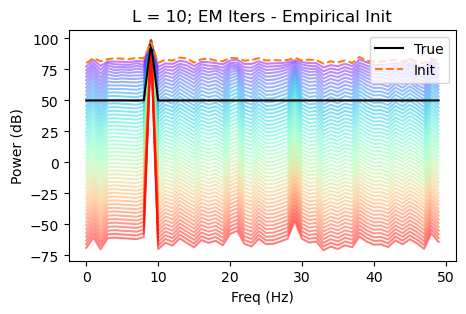

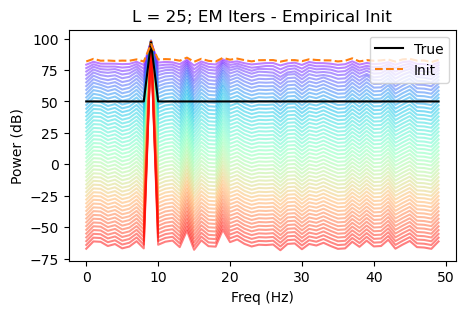

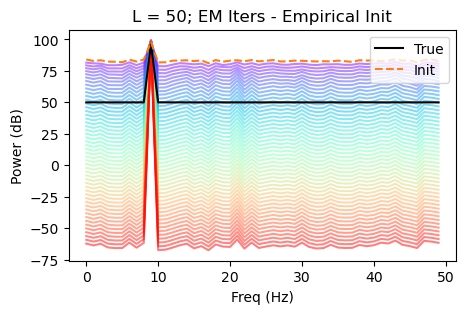

In [10]:
for L in Ls:
    lsel = {'L': L}
    res = filter_loaded(results, lsel, {}, {})

    dB = True
    color = plt.cm.rainbow(jnp.linspace(0, 1, num_iters))
    skip = 0
    fig, ax = plt.subplots(figsize=(5,3))
    for r, c in enumerate(color[skip:]):
        S_r = transform(res['track']['gamma'][r+skip][:,k,k].real, dB=dB)
        ax.plot(S_r, color=c, alpha=0.5)
    S_init = transform(res['gamma_init'][:,k,k].real, dB=dB)
    S_true = transform(gamma_true[nz,k,k].real, dB=dB)
    ax.plot(S_true, color='k', label='True')
    ax.plot(S_init, color='tab:orange', linestyle='--', label='Init')
    ax.set_xlabel('Freq (Hz)')
    if dB is False:
        ax.set_ylabel('Power')
    else: 
        ax.set_ylabel('Power (dB)')
    ax.set_title(f'L = {L}; EM Iters - Empirical Init')
    ax.legend()

In [11]:
# Great - much better behavior

In [12]:
# Unfortunatley, coherence is wacky now!

In [13]:
L = 50
lsel = {'L': L}
res = filter_loaded(results, lsel, {}, {})

gamma_est = res['gamma']
gamma_init = res['gamma_init']

Returned single result.


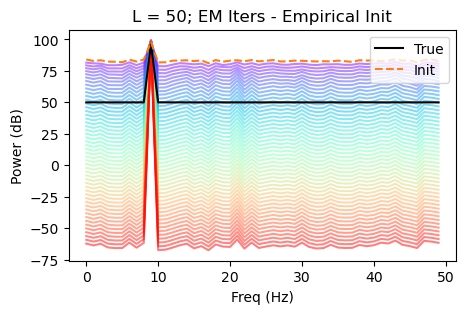

In [14]:
dB = True
color = plt.cm.rainbow(jnp.linspace(0, 1, num_iters))
fig, ax = plt.subplots(figsize=(5,3))
for r, c in enumerate(color):
    S_r = transform(res['track']['gamma'][r][:,k,k].real, dB=dB)
    ax.plot(S_r, color=c, alpha=0.5)
S_init = transform(res['gamma_init'][:,k,k].real, dB=dB)
S_true = transform(gamma_true[nz,k,k].real, dB=dB)
ax.plot(S_true, color='k', label='True')
ax.plot(S_init, color='tab:orange', linestyle='--', label='Init')
ax.set_xlabel('Freq (Hz)')
if dB is False:
    ax.set_ylabel('Power')
else: 
    ax.set_ylabel('Power (dB)')
ax.set_title(f'L = {L}; EM Iters - Empirical Init')
ax.legend()

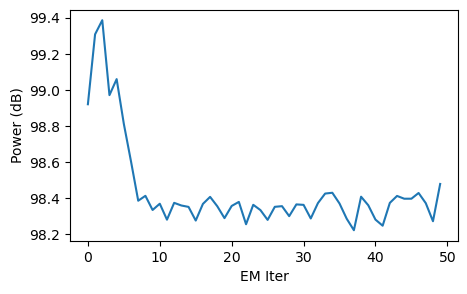

In [15]:
k = 0
skip = 0
init_val = transform(gamma_init[9,k,k].real, dB=dB)
em_target = jnp.array([transform(res['track']['gamma'][r+skip][9,k,k].real, dB=dB) for r in range(num_iters-skip)])
em_target = jnp.insert(em_target, 0, init_val)
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(em_target[1:])
# ax.axhline(transform(gamma_true[9,k,k].real, dB=dB), color='k', linestyle='--', label='True Value')
# ax.legend()
ax.set_xlabel('EM Iter')
if dB is False:
    ax.set_ylabel('Power')
else: 
    ax.set_ylabel('Power (dB)')
# ax.set_title(f'Target value with flat init at {res["cfg"].model.init_mod * gamma_true[9,k,k].real:.2E}')

In [16]:
from cohlib.jax.dists import sample_obs
cfg = res['cfg'] 

lseed = cfg.latent.seed
L = cfg.latent.L

zs = sample_from_gamma(jr.key(lseed), gamma_true, L)

zs_0dc = jnp.apply_along_axis(add0, 0, zs)
xs = jnp.fft.irfft(zs_0dc, axis=0)
ocfg = cfg['obs']
zs_0dc = jnp.apply_along_axis(add0, 0, zs)
xs = jnp.fft.irfft(zs_0dc, axis=0)

obs, obs_params = sample_obs(ocfg, xs)
gamma_naive = naive_estimator(obs, nz)
gamma_oracle = jnp.einsum('jkl,jil->jkil', zs[nz,:,:], zs[nz,:,:].conj()).mean(-1)

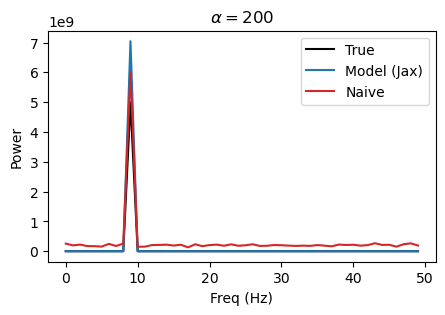

In [17]:
alpha = ocfg.alpha
dB = False 
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(transform(gamma_true[nz,k,k].real, dB=dB), color='k', label='True')
ax.plot(transform(gamma_est[:,k,k].real, dB=dB), label='Model (Jax)')
# ax.plot(transform(gamma_init[:,k,k].real, dB=dB), linestyle='--', color='tab:orange', label='Naive Init')
ax.plot(transform(gamma_naive[:,k,k].real * 1e6, dB=dB), color='tab:red', label='Naive')
ax.set_title(r'$\alpha = $' + f'{alpha}')

ax.set_xlabel('Freq (Hz)')
if dB is False:
    ax.set_ylabel('Power')
else: 
    ax.set_ylabel('Power (dB)')
ax.legend()
# ax.set_xlim([8,12])

(0.0, 1.0)

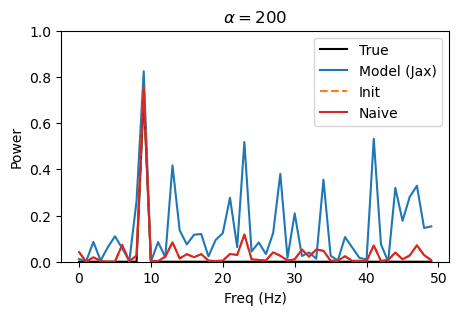

In [18]:
from cohlib.mvcn import thr_coherence
dB = False 
gamma_naive = naive_estimator(obs, nz)
fig, ax = plt.subplots(figsize=(5,3))
ax.plot(thr_coherence(gamma_true[nz,:,:]), color='k', label='True')
ax.plot(thr_coherence(gamma_est[:,:,:]), label='Model (Jax)')
ax.plot(thr_coherence(gamma_init[:,:,:]), linestyle='--', color='tab:orange', label='Init')
ax.plot(thr_coherence(gamma_naive[:,:,:] * 1e6), color='tab:red', label='Naive')
ax.set_title(r'$\alpha = $' + f'{alpha}')

ax.set_xlabel('Freq (Hz)')
if dB is False:
    ax.set_ylabel('Power')
else: 
    ax.set_ylabel('Power (dB)')
ax.legend()
ax.set_ylim([0,1])

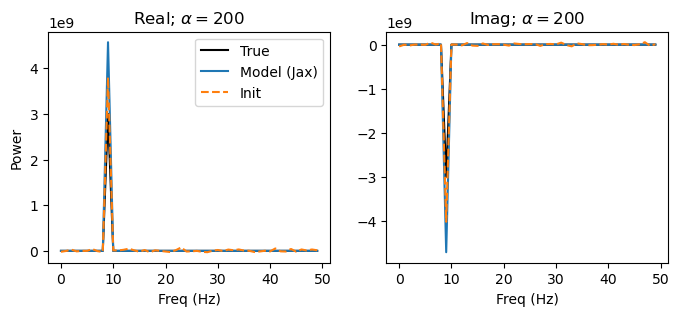

In [172]:
from cohlib.mvcn import thr_coherence
dB = False 
gamma_naive = naive_estimator(obs, nz)
fig, ax = plt.subplots(1, 2, figsize=(8,3))
ax[0].plot(gamma_true[nz,0,1].real, color='k', label='True')
ax[0].plot(gamma_est[:,0,1].real, label='Model (Jax)')
ax[0].plot(gamma_init[:,0,1].real, linestyle='--', color='tab:orange', label='Init')
# ax[0].plot((gamma_naive[:,0,1].real * 1e6).real, color='tab:red', label='Naive')
ax[0].set_title(r'Real; $\alpha = $' + f'{alpha}')

ax[1].plot(gamma_true[nz,0,1].imag, color='k', label='True')
ax[1].plot(gamma_est[:,0,1].imag, label='Model (Jax)')
ax[1].plot(gamma_init[:,0,1].imag, linestyle='--', color='tab:orange', label='Init')
# ax[1].plot((gamma_naive[:,0,1].imag * 1e6).imag, color='tab:red', label='Naive')
ax[1].set_title(r'Imag; $\alpha = $' + f'{alpha}')

ax[0].set_xlabel('Freq (Hz)')
ax[1].set_xlabel('Freq (Hz)')
if dB is False:
    ax[0].set_ylabel('Power')
else: 
    ax[0].set_ylabel('Power (dB)')
ax[0].legend()
# ax.set_ylim([0,1])

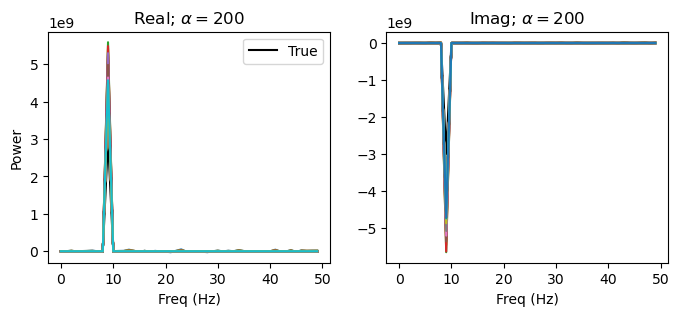

In [173]:
color = plt.cm.rainbow(jnp.linspace(1, 0, num_iters))
dB = False 
gamma_naive = naive_estimator(obs, nz)
fig, ax = plt.subplots(1, 2, figsize=(8,3))
ax[0].plot(gamma_true[nz,0,1].real, color='k', label='True')
for r, c in enumerate(color):
    # S_r = transform(res['track']['gamma'][r][:,k,k].real, dB=dB)
    gamma_est_r = res['track']['gamma'][r]
    ax[0].plot(gamma_est_r[:,0,1].real)
# ax[0].plot(gamma_init[:,0,1].real, linestyle='--', color='tab:orange', label='Init')
# ax[0].plot((gamma_naive[:,0,1].real * 1e6).real, color='tab:red', label='Naive')
ax[0].set_title(r'Real; $\alpha = $' + f'{alpha}')

ax[1].plot(gamma_true[nz,0,1].imag, color='k', label='True')
ax[1].plot(gamma_est[:,0,1].imag, label='Model (Jax)')
for r, c in enumerate(color):
    # S_r = transform(res['track']['gamma'][r][:,k,k].real, dB=dB)
    gamma_est_r = res['track']['gamma'][r]
    ax[1].plot(gamma_est_r[:,0,1].imag)
# ax[1].plot(gamma_init[:,0,1].imag, linestyle='--', color='tab:orange', label='Init')
# ax[1].plot((gamma_naive[:,0,1].imag * 1e6).imag, color='tab:red', label='Naive')
ax[1].set_title(r'Imag; $\alpha = $' + f'{alpha}')

ax[0].set_xlabel('Freq (Hz)')
ax[1].set_xlabel('Freq (Hz)')
if dB is False:
    ax[0].set_ylabel('Power')
else: 
    ax[0].set_ylabel('Power (dB)')
ax[0].legend()
# ax.set_ylim([0,1])

In [151]:
zs.shape

(500, 2, 50)

In [ ]:
# Derp - try this with low coherence on other frequencies instead of 0

In [180]:
mcfg_attrs

{'init': 'empirical-init', 'emiters': 50}

(-10000.0, 10000.0)

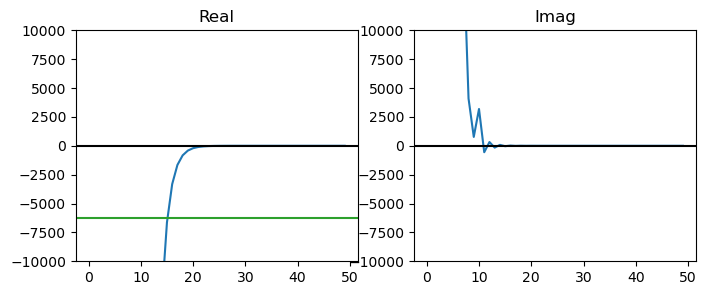

In [23]:
j = 8
target_est_evo_real = jnp.array([res['track']['gamma'][r][j,0,1].real for r in range(num_iters)])
if mcfg_attrs['init'] == 'empirical-diag-init':
    target_est_evo_real = jnp.insert(target_est_evo_real, 0, 0)
true_target_real = gamma_true[j,0,1].real
oracle_target_real = gamma_oracle[j,0,1].real

target_est_evo_imag = jnp.array([res['track']['gamma'][r][j,0,1].imag for r in range(num_iters)])
if mcfg_attrs['init'] == 'empirical-diag-init':
    target_est_evo_imag = jnp.insert(target_est_evo_imag, 0, 0)
true_target_imag = gamma_true[j,0,1].imag
oracle_target_imag = gamma_oracle[j,0,1].imag
fig, ax = plt.subplots(1,2,figsize=(8,3))
ax[0].plot(target_est_evo_real)
ax[0].axhline(true_target_real, color='k')
ax[0].axhline(oracle_target_real, color='tab:green')
ax[0].set_title('Real')
ax[1].plot(target_est_evo_imag)
ax[1].axhline(true_target_imag, color='k')
ax[1].axhline(oracle_target_imag, color='tab:green')
ax[1].set_title('Imag')

lim = 10000
ax[0].set_ylim([-lim,lim])
ax[1].set_ylim([-lim,lim])


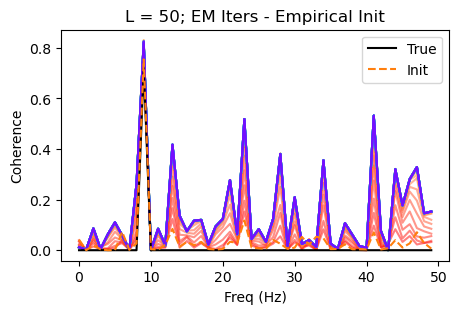

In [175]:
color = plt.cm.rainbow(jnp.linspace(1, 0, num_iters))
fig, ax = plt.subplots(figsize=(5,3))
for r, c in enumerate(color):
    # S_r = transform(res['track']['gamma'][r][:,k,k].real, dB=dB)
    coh_r = thr_coherence(res['track']['gamma'][r])
    ax.plot(coh_r, color=c, alpha=0.5)
# coh_true = thr_coherence(gamma_true[nz,:,:])
# coh_init = thr_coherence(res['gamma_init'])
coh_true = thr_coherence(gamma_true[nz,:,:])
coh_init = thr_coherence(res['gamma_init'])
coh_temp = thr_coherence(res['gamma'])
ax.plot(coh_true, color='k', label='True')
# ax.plot(coh_temp, color='k', label='temp')
ax.plot(coh_init, color='tab:orange', linestyle='--', label='Init')
ax.set_xlabel('Freq (Hz)')
ax.set_ylabel('Coherence')
ax.set_title(f'L = {L}; EM Iters - Empirical Init')
ax.legend()

But, this was not hapening previously? 
... look back at other plots (i.e. from flat init)

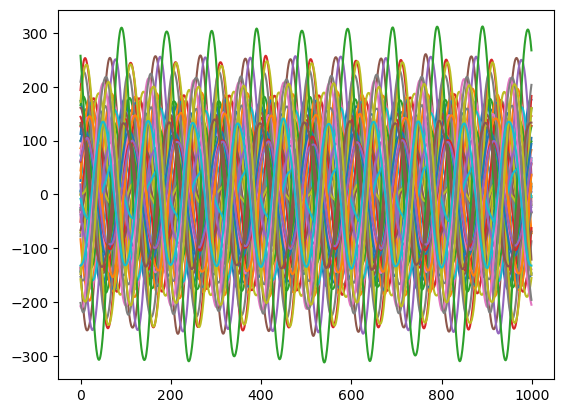

In [51]:
L = xs.shape[-1]
for l in range(L):
    plt.plot(xs[:,0,l])

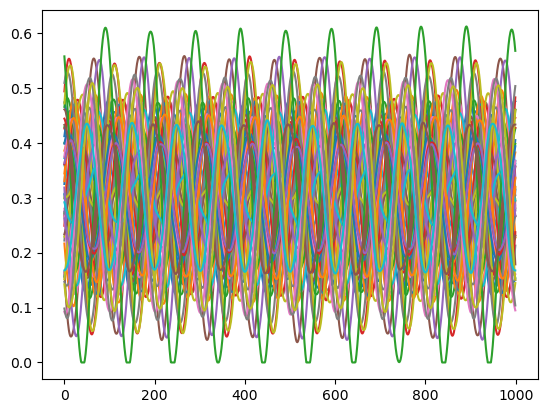

In [52]:
alpha = cfg.obs.alpha
for l in range(L):
    lams = (alpha + xs[:,0,l])*1e-3
    lams = lams.at[lams < 0].set(0)
    plt.plot(lams)